In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/houses_ads_popularity.csv')

# Explotatory Data Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34546 entries, 0 to 34545
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               34546 non-null  int64  
 1   bathrooms        34546 non-null  float64
 2   bedrooms         34546 non-null  int64  
 3   building_id      34546 non-null  object 
 4   created          34546 non-null  object 
 5   description      33509 non-null  object 
 6   display_address  34458 non-null  object 
 7   features         34546 non-null  object 
 8   latitude         34546 non-null  float64
 9   listing_id       34546 non-null  int64  
 10  longitude        34546 non-null  float64
 11  manager_id       34546 non-null  object 
 12  photos           34546 non-null  object 
 13  price            34546 non-null  int64  
 14  street_address   34542 non-null  object 
 15  TARGET           34546 non-null  object 
dtypes: float64(3), int64(4), object(9)
memory usage: 4.2+ MB


Датасет содержит 16 переменных, из которых 7 числовых.

In [ ]:
data.describe()

,Id,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,34546.000000,34546.000000,34546.000000,34546.000000,3.454600e+04,34546.000000,3.454600e+04
mean,61873.351618,1.211182,1.540815,40.741878,7.024901e+06,-73.954803,3.888823e+03
std,35718.160364,0.496217,1.116735,0.622257,1.263556e+05,1.126953,2.630662e+04
min,6.000000,0.000000,0.000000,0.000000,6.811965e+06,-75.521400,4.500000e+01
25%,30839.250000,1.000000,1.000000,40.728000,6.917211e+06,-73.991700,2.500000e+03
50%,61822.500000,1.000000,1.000000,40.751600,7.021834e+06,-73.977900,3.150000e+03
75%,92705.500000,1.000000,2.000000,40.774000,7.130020e+06,-73.954900,4.100000e+03
max,124009.000000,6.000000,8.000000,44.603800,7.742803e+06,0.000000,4.490000e+06


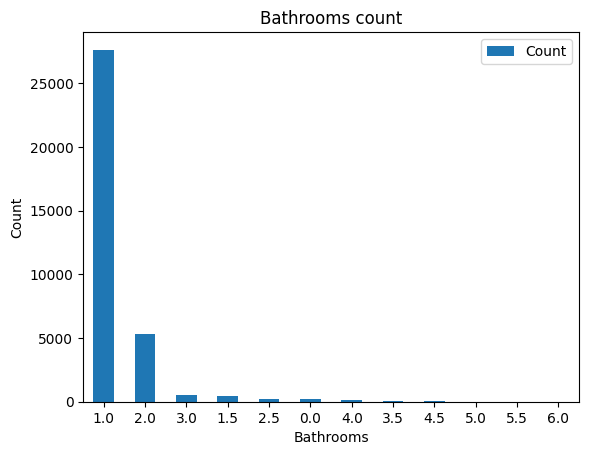

In [ ]:
bathrooms_count = data.bathrooms
fig, ax = plt.subplots()
bathrooms_count.value_counts().plot(kind='bar', ax=ax, xlabel='Bathrooms', ylabel='Count', rot=0)

ax.legend(["Count"]);
ax.set_title('Bathrooms count')
    
plt.show()

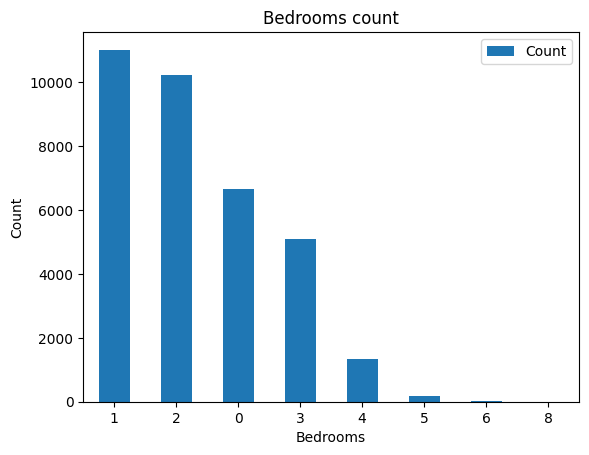

In [ ]:
bedrooms_count = data.bedrooms
fig, ax = plt.subplots()
bedrooms_count.value_counts().plot(kind='bar', ax=ax, xlabel='Bedrooms', ylabel='Count', rot=0)

ax.legend(["Count"]);
ax.set_title('Bedrooms count')
    
plt.show()

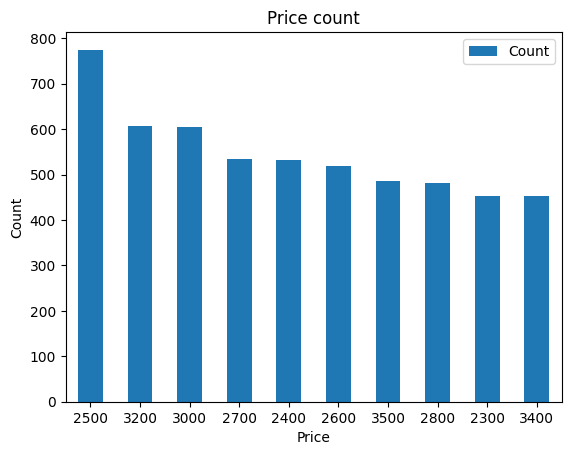

In [ ]:
price_count = data.price
fig, ax = plt.subplots()
price_count.value_counts()[:10].plot(kind='bar', ax=ax, xlabel='Price', ylabel='Count', rot=0)

ax.legend(["Count"]);
ax.set_title('Price count')
    
plt.show()

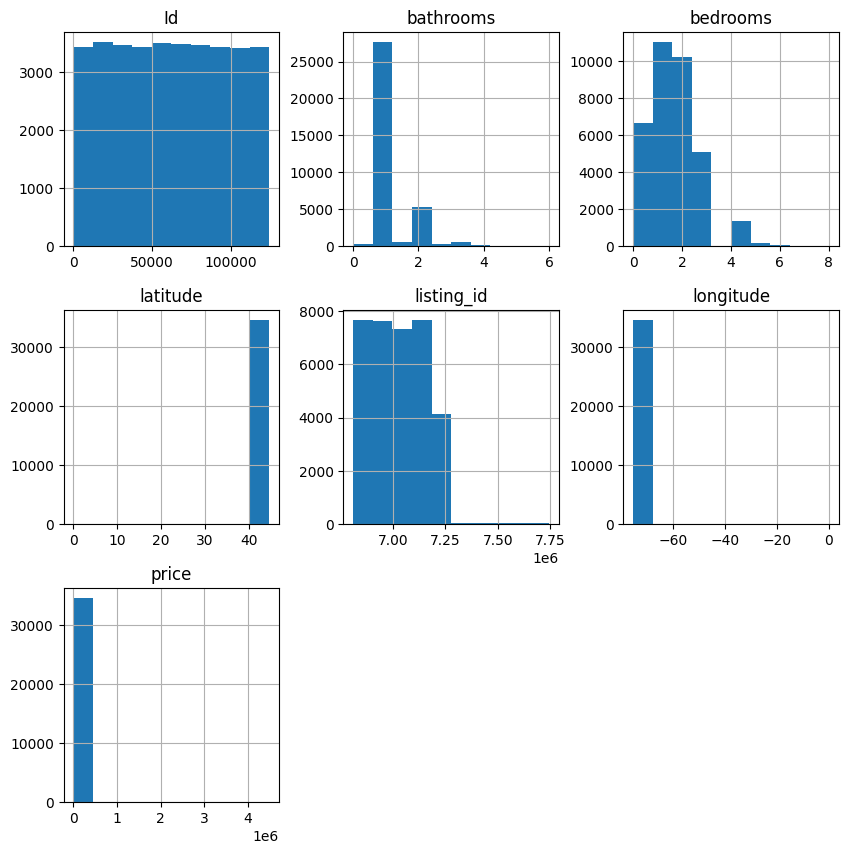

In [ ]:
data.hist(figsize=(10, 10))
plt.show()

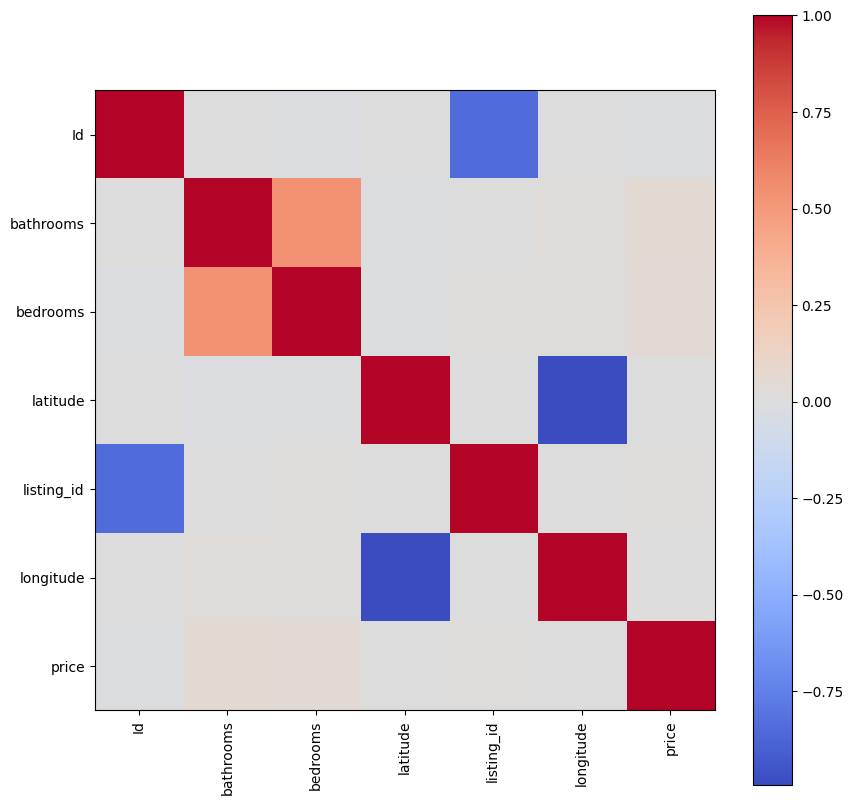

In [ ]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()

По этому графику видно, что есть прямая зависимость между число спален и число ванных комнат, а также обратная зависимость между шириной и долготой. Также на графике видно зависимость между Id и listing_id, однако на мой взгляд эти переменные не оказывают какое-либо существенное влияние на TARGET, так как это лишь уникальные идентификаторы объявлений.

# Feature engineering

In [ ]:
from sklearn.preprocessing import LabelEncoder

new_data = data.copy()
le = LabelEncoder()
new_data['manager_encoded'] = le.fit_transform(data['manager_id'])

In [ ]:
le_2 = LabelEncoder()

new_data['building_encoded'] = le_2.fit_transform(data['building_id'])

In [ ]:
new_data.drop(columns=['manager_id', 'building_id'], inplace=True)

In [ ]:
def count_photos(row):
    return len(eval(row))

new_data['photo_count'] = data['photos'].apply(count_photos)

In [ ]:
description = data['description'].astype(str)

In [ ]:
def str_to_arr(row):
  return eval(row)

new_data['features_new'] = data['features'].apply(str_to_arr)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r"'([^']+)'")

X = vectorizer.fit_transform(data['features'])

features_matrix = X.toarray()

new_df = pd.DataFrame(features_matrix, columns=vectorizer.vocabulary_)

new_data = pd.concat([new_data, new_df], axis=1)


In [ ]:
first_proba_data = new_data.copy().drop(columns=['Id', 'created', 'display_address', 'features', 'photos', 'street_address', 
                                                 'listing_id', 'description', 'features_new'])

In [344]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(first_proba_data, new_data["TARGET"]):
    strat_train_set = first_proba_data.loc[train_index]
    strat_test_set = first_proba_data.loc[test_index]
X_train = strat_train_set.drop(columns=['TARGET'])
y_train = strat_train_set['TARGET']
X_test = strat_test_set.drop(columns=['TARGET'])
y_test = strat_test_set['TARGET']

In [345]:
mean_long = X_train['longitude'].mean()
X_train.loc[X_train['longitude'] == 0, 'longitude'] = mean_long
X_test.loc[X_test['longitude'] == 0, 'longitude'] = mean_long

In [346]:
mean_lat = X_train['latitude'].mean()
X_train.loc[X_train['latitude'] == 0, 'latitude'] = mean_lat
X_test.loc[X_test['latitude'] == 0, 'latitude'] = mean_lat

# Выбор целевой метрики

В качестве целевой метрики я буду использовать **Precision**.

**Precision** хорошо подходит для проблем с несбалансированными классами, так как показывает правильность модели при определении целевого класса.

In [ ]:
counts = data.TARGET.value_counts()
percentages = counts / len(data) * 100
print(percentages)

low       69.469693
medium    22.752272
high       7.778035
Name: TARGET, dtype: float64


Тут видно, что класса 'low' в датасете больше всего, а именно больше 2/3.

Кроме этого precision измеряет насколько точно модель предсказывает положительные случаи. То есть сколько положительных предсказанных моделью случаев также положительны и в датасете.

Возьму также weighted precision, потому что количество элементов каждого класса сильно различается между собой, поэтому так будет нагляднее.

# Проведение экспериментов

Для начала посмотрим разные модели.

In [354]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

y_train_dtc_pred = dtc.predict(X_train)
y_test_dtc_pred = dtc.predict(X_test)

print("Train precision: {}".format(precision_score(y_train, y_train_dtc_pred, average='weighted')))

print("Test precision: {}".format(precision_score(y_test, y_test_dtc_pred, average='weighted')))

Train precision: 0.9836488070544839
Test precision: 0.6742526091994252


In [358]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_train_rfc_pred = rfc.predict(X_train)
y_test_rfc_pred = rfc.predict(X_test)

print("Train precision: {}".format(precision_score(y_train, y_train_rfc_pred, average='weighted')))

print("Test precision: {}".format(precision_score(y_test, y_test_rfc_pred, average='weighted')))

Train precision: 0.9832594963887066
Test precision: 0.6792349362230226


In [359]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()

etc.fit(X_train, y_train)

y_train_etc_pred = etc.predict(X_train)
y_test_etc_pred = etc.predict(X_test)

print("Train precision: {}".format(precision_score(y_train, y_train_etc_pred, average='weighted')))

print("Test precision: {}".format(precision_score(y_test, y_test_etc_pred, average='weighted')))

Train precision: 0.9836488070544839
Test precision: 0.6608897861005611


In [361]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

y_train_gbc_pred = gbc.predict(X_train)
y_test_gbc_pred = gbc.predict(X_test)

print("Train precision: {}".format(precision_score(y_train, y_train_gbc_pred, average='weighted')))

print("Test precision: {}".format(precision_score(y_test, y_test_gbc_pred, average='weighted')))

Train precision: 0.7129267746263463
Test precision: 0.6792365861129988


In [363]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()

abc.fit(X_train, y_train)


y_train_abc_pred = abc.predict(X_train)
y_test_abc_pred = abc.predict(X_test)

print("Train precision: {}".format(precision_score(y_train, y_train_abc_pred, average='weighted')))

print("Test precision: {}".format(precision_score(y_test, y_test_abc_pred, average='weighted')))

Train precision: 0.6821604061017028
Test precision: 0.6691074192953879


По итогу обучения нескольких моделей видно, что деревья хорошо обучаются на тренировочной выборке, но на тестовой не очень. А другие примерно одинаково.

In [373]:
n_estimators_list = [50, 100, 200, 500]

rfc_n = RandomForestClassifier(random_state=42)

for n_estimators in n_estimators_list:
    rfc_n.set_params(n_estimators=n_estimators)
    
    rfc_n.fit(X_train, y_train)
    
    y_train_rfc_n_pred = rfc_n.predict(X_train)
    y_test_rfc_n_pred = rfc_n.predict(X_test)
    
    print("Количество деревьев: ", n_estimators)
    print("Train precision: {}".format(precision_score(y_train, y_train_rfc_n_pred, average='weighted')))
    print("Test precision: {}".format(precision_score(y_test, y_test_rfc_n_pred, average='weighted')))

Количество деревьев:  50
Train precision: 0.9831544747510609
Test precision: 0.6702938301536584
Количество деревьев:  100
Train precision: 0.9832642452821959
Test precision: 0.6806970455251813
Количество деревьев:  200
Train precision: 0.9832644669098513
Test precision: 0.6803965792269726
Количество деревьев:  500
Train precision: 0.9832578327695304
Test precision: 0.6814006672699078


При увеличении числа деревьев precision приближается к 1, однако этот рост настолько мал.

In [ ]:
max_features_list = [2, 3, 4]

rfc_n = RandomForestClassifier(random_state=42, n_estimators=50)

for max_features in max_features_list:
    rfc_n.set_params(max_features=max_features)
    
    rfc_n.fit(X_train, y_train)
    
    y_train_rfc_n_pred = rfc_n.predict(X_train)
    y_test_rfc_n_pred = rfc_n.predict(X_test)
    
    print("Количество признаков: ", max_features)
    print("Train precision: {}".format(precision_score(y_train, y_train_rfc_n_pred, average='weighted')))
    print("Test precision: {}".format(precision_score(y_test, y_test_rfc_n_pred, average='weighted')))

Количество признаков:  2
Train precision: 0.9830462707763571
Test precision: 0.6721935868631589
Количество признаков:  3
Train precision: 0.9831139685931338
Test precision: 0.6728178731019604
Количество признаков:  4
Train precision: 0.9831264692786998
Test precision: 0.6789487614959083


При увеличении числа признаков ничего особенного не происходит.

In [381]:
max_depth_list = [10, 20, 50, 100, 500]

rfc_n = RandomForestClassifier(random_state=42, n_estimators=50, max_features=3)

for max_depth in max_depth_list:
    rfc_n.set_params(max_depth=max_depth)
    
    rfc_n.fit(X_train, y_train)
    
    y_train_rfc_n_pred = rfc_n.predict(X_train)
    y_test_rfc_n_pred = rfc_n.predict(X_test)
    
    print("Максимальная глубина: ", max_depth)
    print("Train precision: {}".format(precision_score(y_train, y_train_rfc_n_pred, average='weighted', zero_division=1)))
    print("Test precision: {}".format(precision_score(y_test, y_test_rfc_n_pred, average='weighted', zero_division=1)))

Максимальная глубина:  10
Train precision: 0.787946835311976
Test precision: 0.7878868478536318
Максимальная глубина:  20
Train precision: 0.7880866041193676
Test precision: 0.6741778026189983
Максимальная глубина:  50
Train precision: 0.8125304928788448
Test precision: 0.641100617761855
Максимальная глубина:  100
Train precision: 0.9637575329402045
Test precision: 0.66637407531994
Максимальная глубина:  500
Train precision: 0.9831139685931338
Test precision: 0.6728178731019604


# Анализ ошибок модели

In [400]:
rfc_n_10 = RandomForestClassifier(random_state=42, n_estimators=50, max_features=3, max_depth=10)
rfc_n_10.fit(X_train, y_train)
    
y_train_rfc_n10_pred = rfc_n_10.predict(X_train)
y_test_rfc_n10_pred = rfc_n_10.predict(X_test)

print("Train precision: {}".format(precision_score(y_train, y_train_rfc_n10_pred, average='weighted', zero_division=1)))
print("Test precision: {}".format(precision_score(y_test, y_test_rfc_n10_pred, average='weighted', zero_division=1)))

Train precision: 0.787946835311976
Test precision: 0.7878868478536318


Возьму модель, которая лучше всего предсказала, то есть с глубиной 10.

In [403]:
pd.DataFrame(data={'pred': y_test_rfc_n10_pred, 'test': y_test}).head(10)

,pred,test
8469,low,high
15990,low,low
8948,low,low
2890,low,medium
15401,low,low
15374,low,low
14892,low,low
26903,low,high
12298,low,low
29936,low,low


При более детальном изучении предсказаний можно увидеть, что модель просто постоянно предсказыает класс 'low'. Что, конечно же, не есть хорошо, однако такая модель пресказывает лучше других.

In [404]:
pd.DataFrame(data={'pred': y_test_rfc_n10_pred}).value_counts()

pred
low     6910
dtype: int64

На самом деле видимо эта модель не искала каких-то особенных правил, а просто поняла, что большинством занимает класс 'low'.

In [405]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

y_train_dtc_pred = dtc.predict(X_train)
y_test_dtc_pred = dtc.predict(X_test)

print("Train precision: {}".format(precision_score(y_train, y_train_dtc_pred, average='weighted')))

print("Test precision: {}".format(precision_score(y_test, y_test_dtc_pred, average='weighted')))

Train precision: 0.9836488070544839
Test precision: 0.6778469610152567


In [406]:
pd.DataFrame(data={'pred': y_test_dtc_pred, 'test': y_test}).head(10)

,pred,test
8469,medium,high
15990,low,low
8948,low,low
2890,medium,medium
15401,low,low
15374,low,low
14892,low,low
26903,medium,high
12298,low,low
29936,low,low


In [410]:
X_test.loc[8469], y_test[8469]

(bathrooms                                                                                               1.0000
 bedrooms                                                                                                2.0000
 latitude                                                                                               40.7967
 longitude                                                                                             -73.9623
 price                                                                                                2900.0000
                                                                                                        ...    
 700 sf                                                                                                  0.0000
 new                                                                                                     0.0000
 total reno. heart of west village                                                                      

In [411]:
X_test.loc[26903], y_test[26903]

(bathrooms                                                                                               1.0000
 bedrooms                                                                                                3.0000
 latitude                                                                                               40.7513
 longitude                                                                                             -73.9721
 price                                                                                                3995.0000
                                                                                                        ...    
 700 sf                                                                                                  0.0000
 new                                                                                                     0.0000
 total reno. heart of west village                                                                      

Тут я уже взял уже другую модель. Сразу видно, что модель также хорошо определяет класс 'low', а с другими классами возникают проблемы, однако класс 'medium' модель все же определяет успешнее, чем класс 'high'. Это связано с количеством таких данных в тренировочной выборке, а также с количеством признаков. На мой взгляд я сделал слишком много признаков из столбца features, которые возможно особо не должны влиять на модель, но за счет количества все же получается слишком большое влияние.

In [412]:
pd.DataFrame(data={'pred': y_test_dtc_pred}).value_counts()

pred  
low       4791
medium    1598
high       521
dtype: int64